# Проект

## Цели

- Сформировать признаки, которые наилучшим образом выделяют конкретного пользователя по его поведению в сети
- Построение модели, которая способна идентифицировать конкретного пользователя среди других на основе сгенерированных признаков


## Задачи

- Предобработать исходные данные
- Провести анализ признаков, построенных на основе исходных данных:
    - выявление взаимосвязи признака и целевой метки
    - визуализация признаков в срезе целевой метки
- Удалить наименнее информативные признаки на основе некоторого критерия
- Поиск наилучшей модели на основе кросс-валидации
- Применение наилучшей модели к тестовому набору данных

## Описание

Будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.

## Критерий оценивания

Целевая метрика – $ROC-AUC$

# Первичная настройка

## Подключение модулей/функций

In [98]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
import eli5
import xgboost as xgb

from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score,\
                                    GridSearchCV, train_test_split


from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import cluster

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from IPython.display import display_html

import warnings
warnings.filterwarnings('ignore', category=FutureWarning,
                        module='sklearn.utils.deprecation')

## Считывание данных и первичная настройка


Фиксирования константы для ГПСЧ

In [2]:
RANDOM_SEED = 7

Путь к данным

In [3]:
PATH_TO_DATA = 'kaggle_data/'

Считываем наборы данных для обучения и тестирования

In [4]:
train_df = pd.read_csv(PATH_TO_DATA + 'train_sessions.csv',
                       index_col='session_id', parse_dates=['time1'])
test_df = pd.read_csv(PATH_TO_DATA + 'test_sessions.csv',
                      index_col='session_id', parse_dates=['time1'])

times = [f'time{i}' for i in range(1, 11)]
sites = [f'site{i}' for i in range(1, 11)]

In [5]:
print(f'Размерность тренировочных данных: {train_df.shape}')
print(f'Размерность тестовых данных: {test_df.shape}')

Размерность тренировочных данных: (253561, 21)
Размерность тестовых данных: (82797, 20)


# Анализ данных

## Целевая переменная

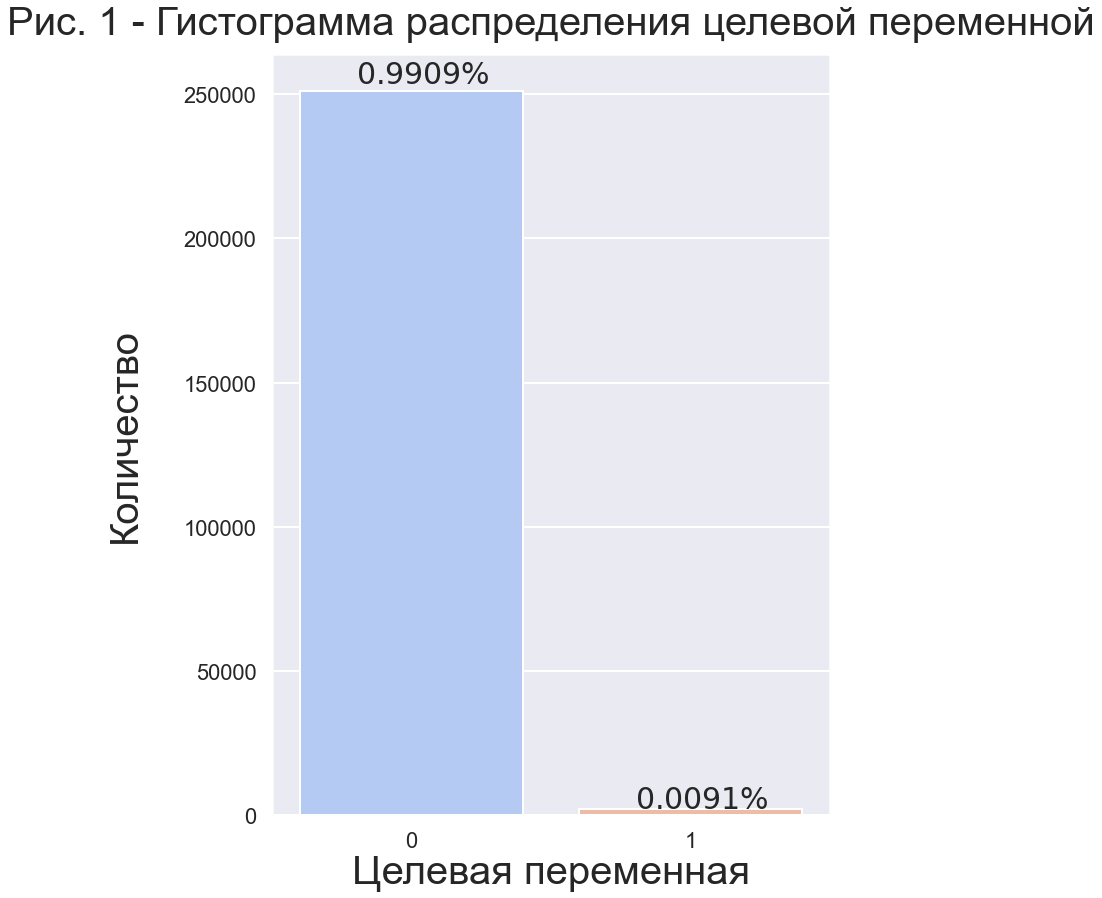

In [7]:
user_count = sum(train_df['target'] == 0)
Alice_count = sum(train_df['target'] == 1) 
user_perc = round(user_count/len(train_df['target']), 4)
Alice_perc = round(Alice_count/len(train_df['target']), 4)

fig, ax = plt.subplots(figsize=(10, 14))
sns.set_context('poster')
plt.title('Рис. 1 - Гистограмма распределения целевой переменной',
          fontsize=40, pad=20)
sns.countplot(x=train_df['target'], palette='coolwarm', ax=ax)
plt.xlabel('Целевая переменная', fontsize=40)
ax.annotate(f'${str(user_perc)} \%$', xy=(-.2, user_count*1.01),  xycoords='data',
            xytext=(0, 0), textcoords='offset points',
            size=30, ha='left')
ax.annotate(f'${str(Alice_perc)} \%$', xy=(0.8, Alice_count*1.05),  xycoords='data',
            xytext=(0, 0), textcoords='offset points',
            size=30, ha='left')
plt.ylabel('Количество', fontsize=40, labelpad=40);

По графику видно, что распределение очень несбалансировано. Данные об Алисе составляют всего $0.0091\%$ от общего количества. Смотреть на долю верных ответов (accuracy) непоказательно.

## Преобразование данных

Переведем все временные данный в формат `datetime`. Отсортируем данные по времени и заполним все пропуски нулями.

In [8]:
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
train_df = train_df.sort_values(by='time1')
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

## Анализ сайтов

Загрузим далее словарь сайтов и на его основе создадим отдельный `DataFrame`.

In [9]:
with open(PATH_TO_DATA + 'site_dic.pkl', 'rb') as file:
    site_dict = pickle.load(file)
    
sites_dict = pd.DataFrame(list(site_dict.keys()),
                          index=list(site_dict.values()),
                          columns=['site'])
print('Всего разных сайтов:', sites_dict.shape[0])

Всего разных сайтов: 48371


Посмотрим на топ $10$ сайтов.

In [10]:
top_sites = pd.Series(train_df[train_df[sites] != 0][sites].values.flatten())\
              .value_counts().sort_values(ascending=False).head(10)

top_sites = pd.DataFrame(top_sites, columns=['Количество посещений'])
top_sites['Название сайта'] = sites_dict.loc[top_sites.index, :].values

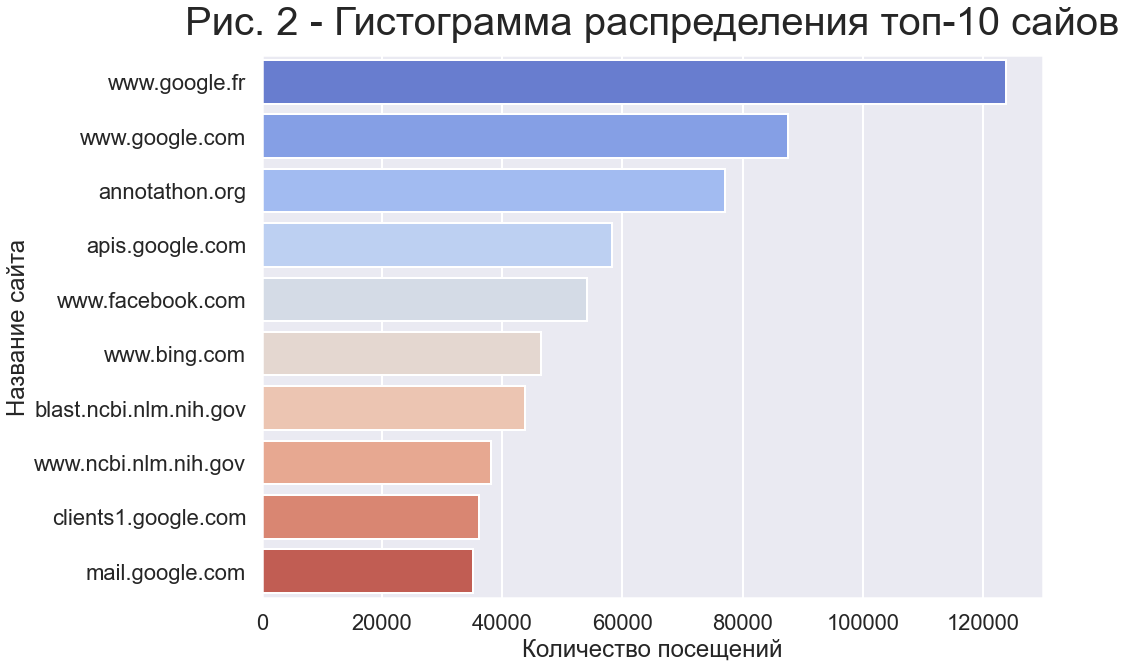

In [11]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.set_context('poster')
plt.title('Рис. 2 - Гистограмма распределения топ-10 сайов',
          fontsize=40, pad=20)
sns.barplot(x='Количество посещений', y='Название сайта', data=top_sites,
            palette='coolwarm', ax=ax);

Самым популярным оказался сайт google, что неудивительно. Из знакомых сайтов также можем увидеть facebook и bing. 

Узнаем предпочтения Алисы.

In [12]:
top_sites_alice = pd.Series(train_df[train_df.target==1][sites].fillna(0)\
                            .values.flatten()).value_counts()\
                            .sort_values(ascending=False).head(10)

top_sites_alice = pd.DataFrame(top_sites_alice, columns=['Количество посещений'])
top_sites_alice['Название сайта'] = sites_dict.loc[top_sites_alice.index, :].values

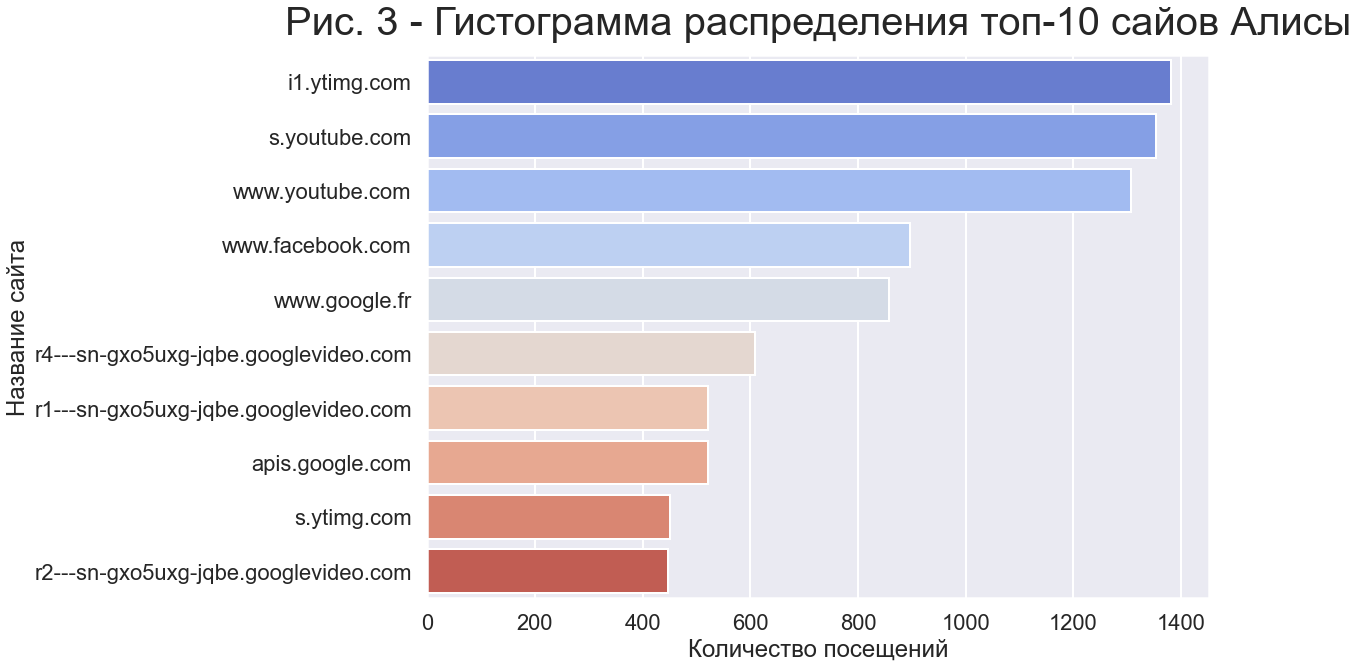

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.set_context('poster')
plt.title('Рис. 3 - Гистограмма распределения топ-10 сайов Алисы',
          fontsize=40, pad=20)
sns.barplot(x='Количество посещений', y='Название сайта', data=top_sites_alice,
            palette='coolwarm', ax=ax);

На рис. 3 видно, что есть знакомые сайты, как и из предыдущего топа, однако большенство сайтов отличаются от того топа, который был предстален выше. 

## Анализ сессий

Выделим для каждой сессии начало и конец, также вычислим длительность сессии в секундах

In [14]:
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

In [15]:
time_df_test = pd.DataFrame(index=test_df.index)

time_df_test['min'] = test_df[times].min(axis=1)
time_df_test['max'] = test_df[times].max(axis=1)

time_df_test['seconds'] = (time_df_test['max'] - time_df_test['min']) / np.timedelta64(1, 's')

`y_train` - наша целевая переменная

`full_df` - объединенная таблица входных данных (обучающая и тестовая выборки вместе)

`idx_split` - индекс, по которому мы будем отделять обучающую выборку от теста

In [16]:
y_train = train_df['target']

full_df = pd.concat([train_df.drop('target', axis=1), test_df])

idx_split = train_df.shape[0]

Сформируем DataFrame, в котором хранятся только сайты

In [17]:
full_sites = full_df[sites]
full_sites.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946


# Создание признаков

Извлечем атрибуты из таблицы сайта

Подсчитаем количество уникальных сайтов в каждом сеансе

In [18]:
%%time

unique_count = []
for row in full_sites.values:
    unique = np.unique (row)
    if 0 in unique:
        unique_count.append(len(unique) - 1)
    else:
        unique_count.append(len(unique))
unique_count = np.array(unique_count).reshape(-1,1)

CPU times: user 3.86 s, sys: 17 ms, total: 3.88 s
Wall time: 3.89 s


In [19]:
additional_data_df  =  pd.DataFrame(data = unique_count,
                                    columns = ['unique'],
                                    index = full_df.index)

Создим словарь, где ключами являются сайты, а значениями - количество сеансов, в которых этот сайт встречался.

In [20]:
site_dict = {} 
for row in full_sites.values: 
    for site_id in np.unique(row): 
        if site_id in site_dict: 
            site_dict[site_id] += 1 
        else: 
            site_dict[site_id] = 1 
site_dict.pop(0)

30500

Сделаем индикатор присутствия на сайте того сайта, который входит в топ-10 популярных сайтов

In [21]:
%%time
top_10 = sorted(list(site_dict.items()), key=lambda tup: tup [1], 
                 reverse = True)[: 10]
top_10 = [element [0] for element in top_10]
have_top_10 = np.zeros ((full_sites.shape [0], 1), dtype = int)
ind = 0
for row in full_sites.values:
    unique = np.unique (row)
    for site_id in unique:
        if site_id in top_10:
            have_top_10[ind] = 1
    ind += 1

have_top_10

CPU times: user 3.62 s, sys: 48.5 ms, total: 3.67 s
Wall time: 3.65 s


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [22]:
additional_data_df['have_top_10'] = have_top_10

In [23]:
additional_data_df.head(3)

,unique,have_top_10
session_id,,
21669,2,0
54843,2,0
77292,6,0


Подсчитаем количество абсолютно уникальных сайтов в сеансе.

In [24]:
absolutely_unique_count  =  np.zeros((full_sites.shape[0], 1 ), 
                                     dtype = int ) 
ind = 0 
for row in full_sites.values : 
    unique = np.unique(row) 
    absolutely_unic_row = {} 
    for site_id in unique : 
        if (site_id !=0) and (site_dict[site_id] == 1) and (site_id not in absolutely_unic_row): 
            absolutely_unique_count[ind] += 1 
            absolutely_unic_row[site_id] = 1 
    ind += 1

In [25]:
additional_data_df['absolutely_unique_count'] = absolutely_unique_count

Сделаем индикатор наличия абсолютно уникального сайта в сессии.

In [26]:
absolutely_unique = (absolutely_unique_count > 0 ).astype(int)
additional_data_df['have_absolutely_unique'] = absolutely_unique

In [27]:
additional_data_df['absolutely_unique_count']

session_id
21669     0
54843     0
77292     0
114021    0
146670    0
         ..
82793     0
82794     0
82795     0
82796     0
82797     0
Name: absolutely_unique_count, Length: 336358, dtype: int64

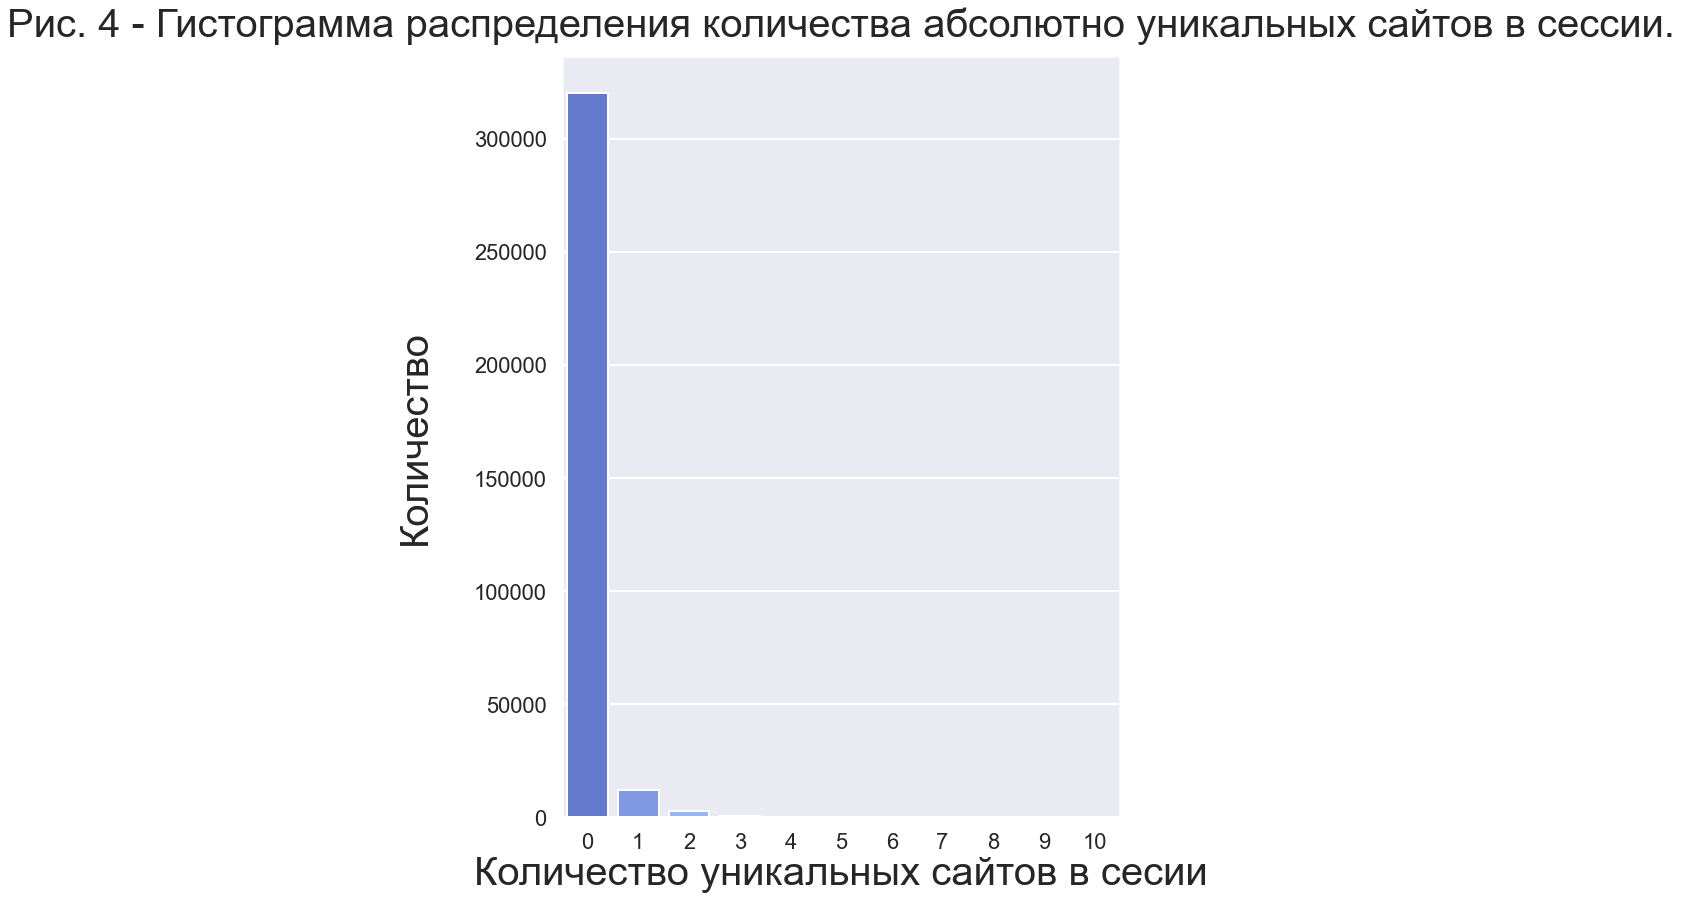

In [28]:
fig, ax = plt.subplots(figsize=(10, 14))
sns.set_context('poster')

sns.countplot(x=additional_data_df['absolutely_unique_count'],
               palette='coolwarm', ax=ax);
plt.title('Рис. 4 - Гистограмма распределения количества абсолютно уникальных сайтов в сессии.',
          fontsize=40, pad=20)
plt.xlabel('Количество уникальных сайтов в сесии', fontsize=40)
plt.ylabel('Количество', fontsize=40, labelpad=40);

## Признаки, связанные со временем

Извлечем таблицу, в которой будут только временные столбцы

In [29]:
full_time = full_df[times] 
full_time.head(3)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17


Далее рассчитаем время пребывания на каждом сайте в течение одной сессии.

In [30]:
def get_time_diff(row): 
    time_length = row.shape[0] - 1 
    time_diff = [0]*time_length 
    i = 0 
    while (i < time_length) and pd.notnull(row[i + 1]): 
        time_diff[i] = (row[i+1] - row[i])/np.timedelta64(1, 's') 
        i += 1 
    return  time_diff

In [31]:
%%time
time_diff = []
for row in full_time.values:
    time_diff.append(get_time_diff(row))

time_diff = np.log1p(np.array(time_diff).astype(float))

CPU times: user 24.6 s, sys: 137 ms, total: 24.8 s
Wall time: 24.8 s


Добавим новые признаки в `additional_data_df`

In [32]:
time_names = ['time_diff' + str(j) for j in range(1, 10)] 
for ind, column_name in enumerate(time_names): 
    additional_data_df[column_name] = time_diff[:, ind] 

Далее рассчитаем общее время, затраченное на каждую сессию.

In [33]:
def get_total_time(row): 
    time_length = row.shape[0] - 1 
    i = time_length 
    while pd.isnull(row[i]): 
        i -= 1 
    return (row[i] - row[0])/np.timedelta64(1, 's')

In [34]:
%%time
total_time = []
for row in full_time.values:
    total_time.append(get_total_time(row))
    
total_time = np.array(total_time).reshape(-1, 1).astype(int)

CPU times: user 3.22 s, sys: 26.6 ms, total: 3.24 s
Wall time: 3.26 s


Добавим новые признаки в `additional_data_df`

In [35]:
additional_data_df['total_time'] = total_time 
additional_data_df['total_time'] = np.log1p(additional_data_df['total_time'].values)

Добавим также в качестве новых признаков:

- `start_hour` - час, с которого начинается сессия
- `holiday` - индикатор выходных
- `day_of_week` - день недели

In [36]:
additional_data_df['start_hour'] = full_time['time1'].apply(lambda ts: ts.hour) 
additional_data_df['holiday'] = (full_time['time1'].dt.dayofweek >= 5).astype(int) 
additional_data_df['day_of_week'] = (full_time['time1'].dt.dayofweek).astype(int)

Посмотрим на `additional_data_df`

In [37]:
additional_data_df.head(3)

,unique,have_top_10,absolutely_unique_count,have_absolutely_unique,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,total_time,start_hour,holiday,day_of_week
session_id,,,,,,,,,,,,,,,,,
21669,2,0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,8,1,5
54843,2,0,0,0,0.000000,7.487174,1.098612,0.000000,0.0,0.0,0.0,0.000000,0.0,7.488294,8,1,5
77292,6,0,0,0,0.693147,0.693147,0.000000,0.693147,0.0,0.0,0.0,0.693147,0.0,1.609438,8,1,5


In [38]:
add_data_train = additional_data_df[:idx_split].copy() 
add_data_test = additional_data_df[idx_split:]

# Анализ обучающей и тренировочной выборок

In [39]:
add_data_train.loc[:, 'target'] = y_train

Посмотрим на наши признаки, которые мы сформировали ранее, с точки зрения типа данных

In [40]:
dtype_df = add_data_train.dtypes.reset_index() 
dtype_df.columns = ['Column_name', 'Column_type'] 
dtype_df

,Column_name,Column_type
0,unique,int64
1,have_top_10,int64
2,absolutely_unique_count,int64
3,have_absolutely_unique,int64
4,time_diff1,float64
5,time_diff2,float64
6,time_diff3,float64
7,time_diff4,float64
8,time_diff5,float64
9,time_diff6,float64


Почти все признаки имеют тип `int64`, но их можно разделить на две группы -

1. Категориальные данные

2. Количественные данные

Давайте посмотрим на матрицу корреляции признаков

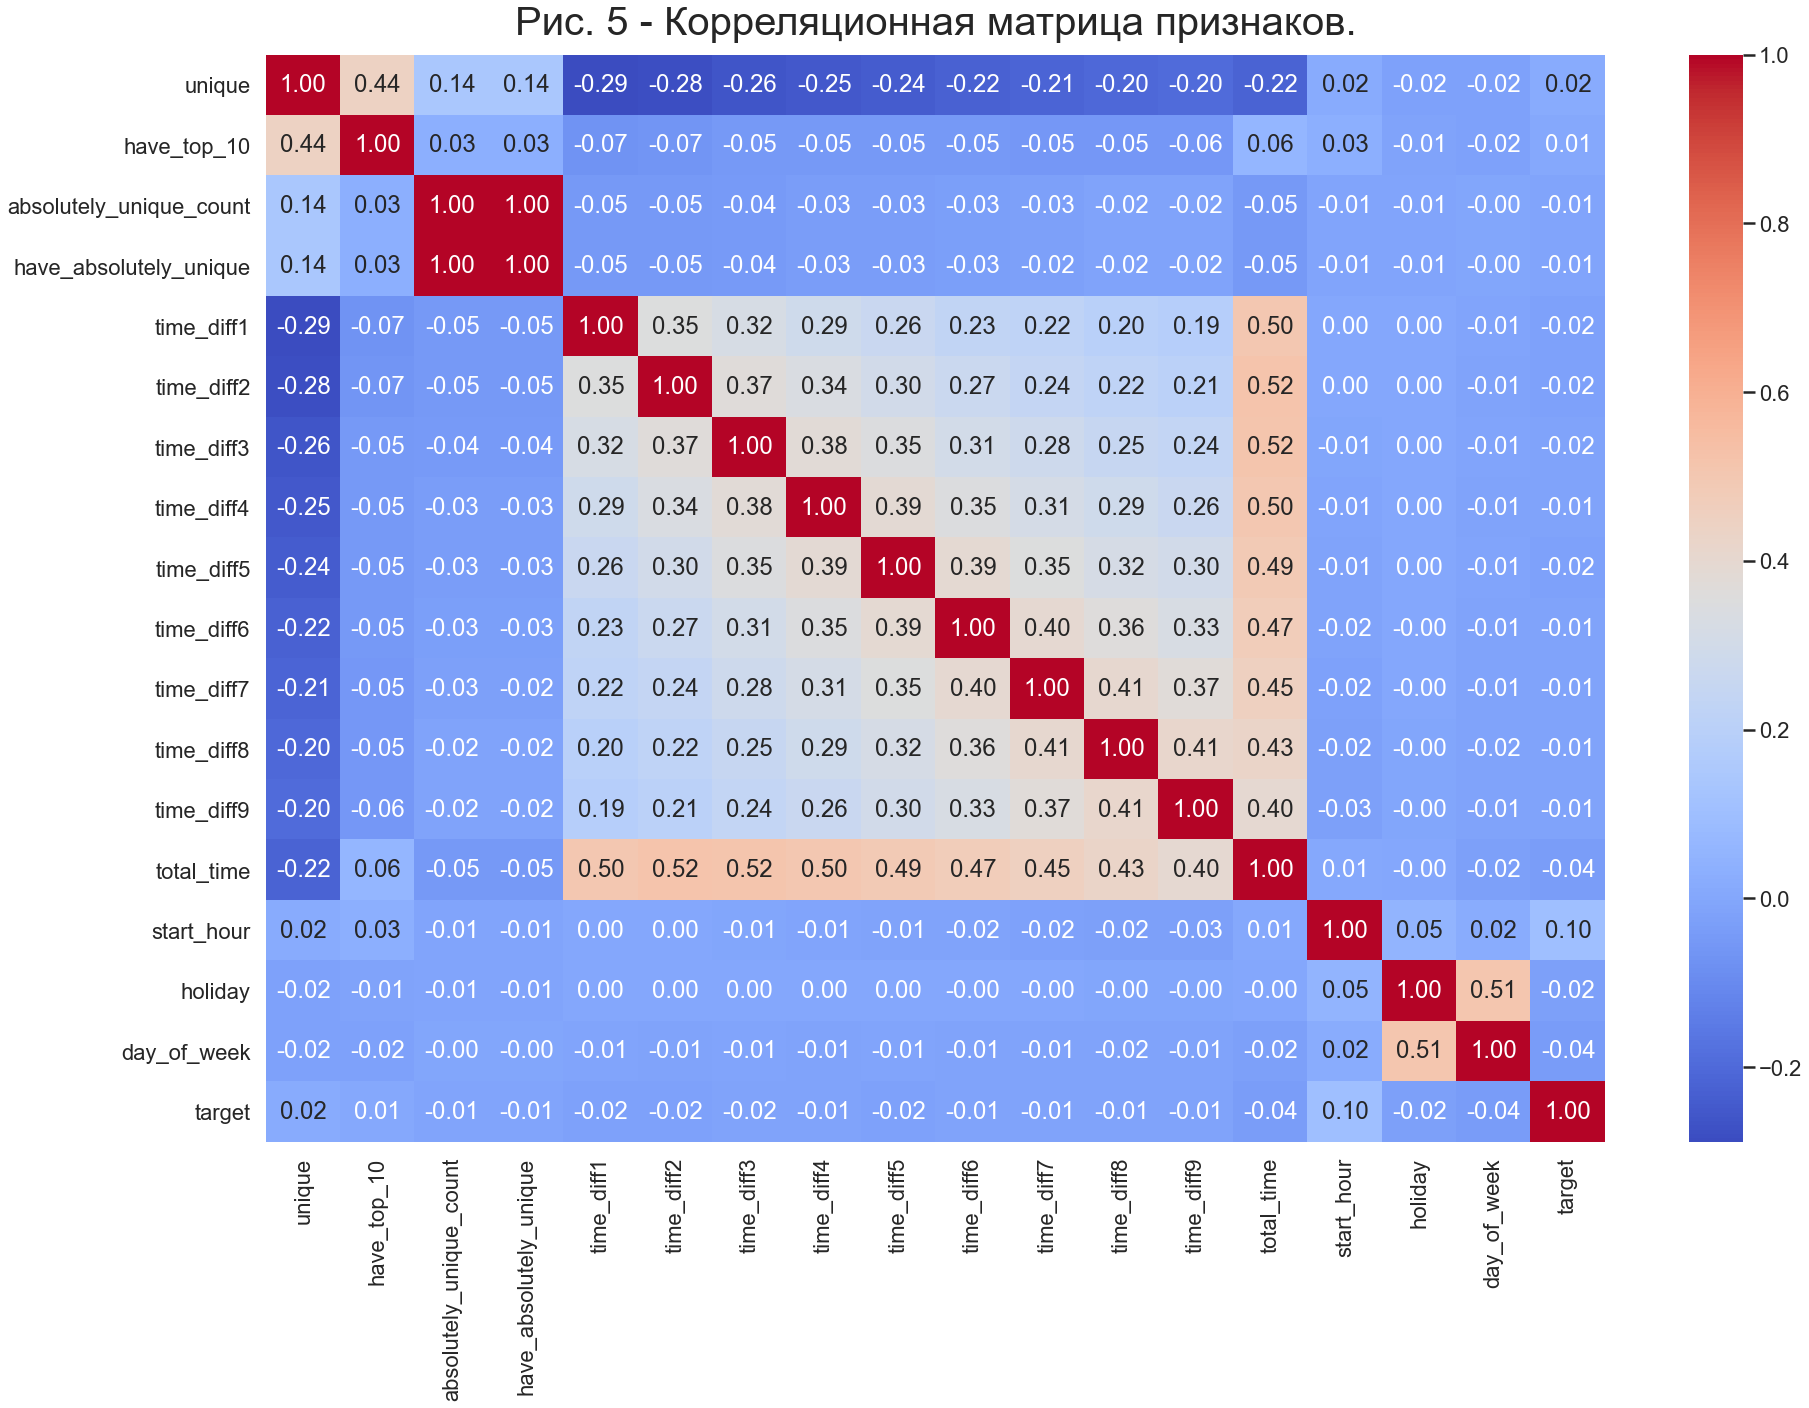

In [41]:
corr = add_data_train.corr('spearman') 
plt.figure(figsize=(30, 20)) 
sns.heatmap(corr, annot=True, fmt='.2f', cmap="coolwarm")
plt.title('Рис. 5 - Корреляционная матрица признаков.',
          fontsize=40, pad=20);

Давайте рассмотрим распределение некоторых признаков

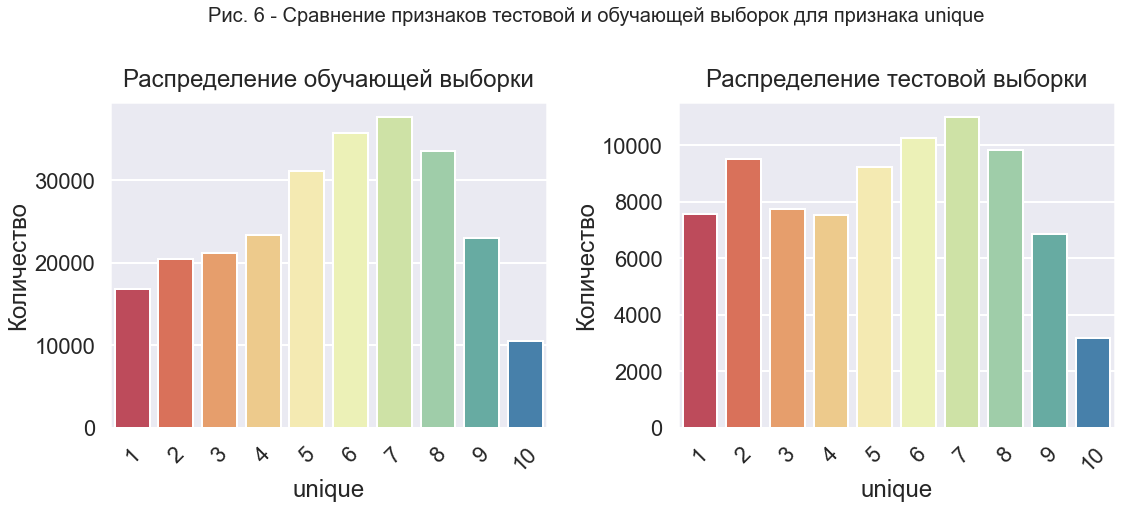

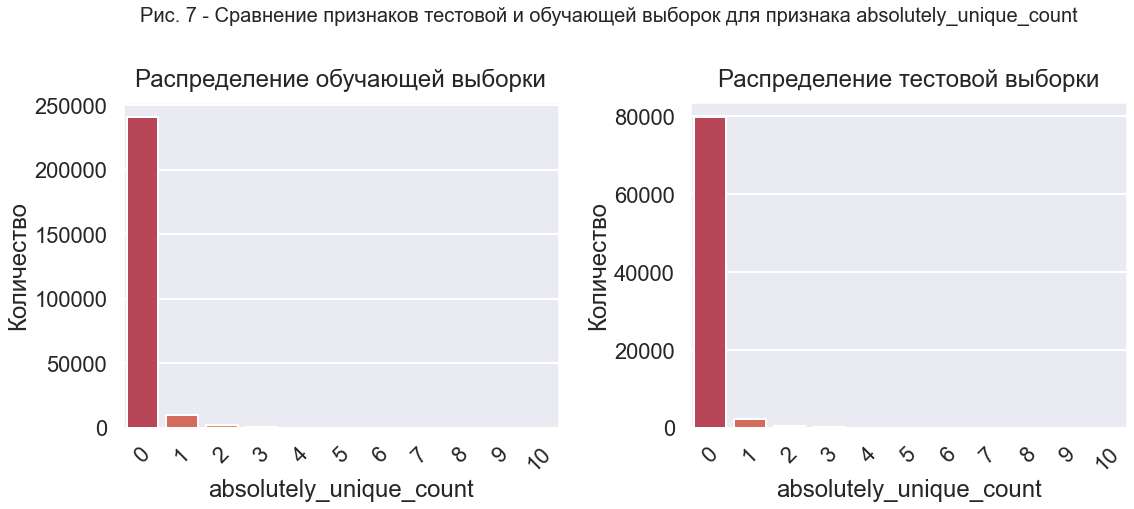

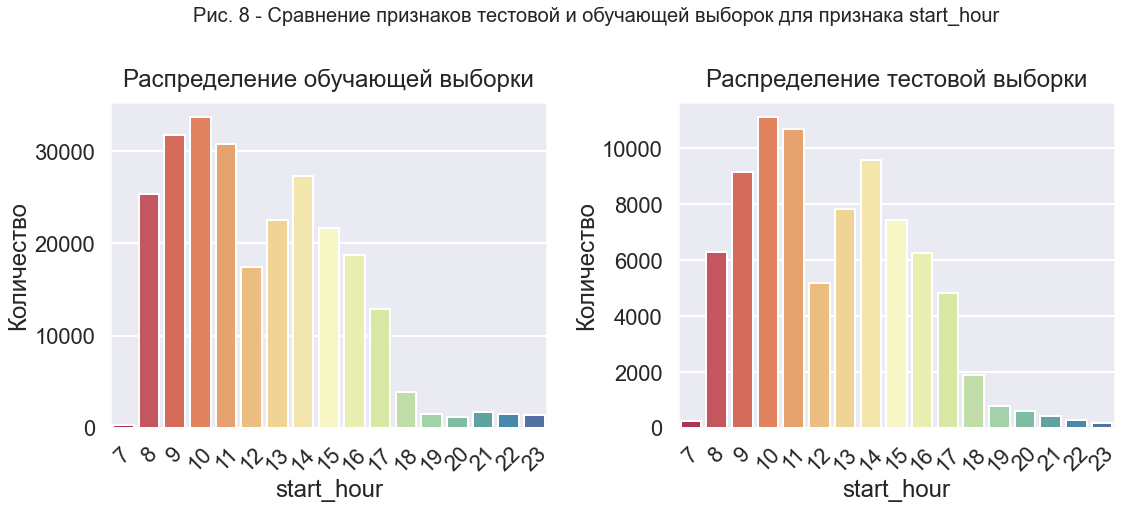

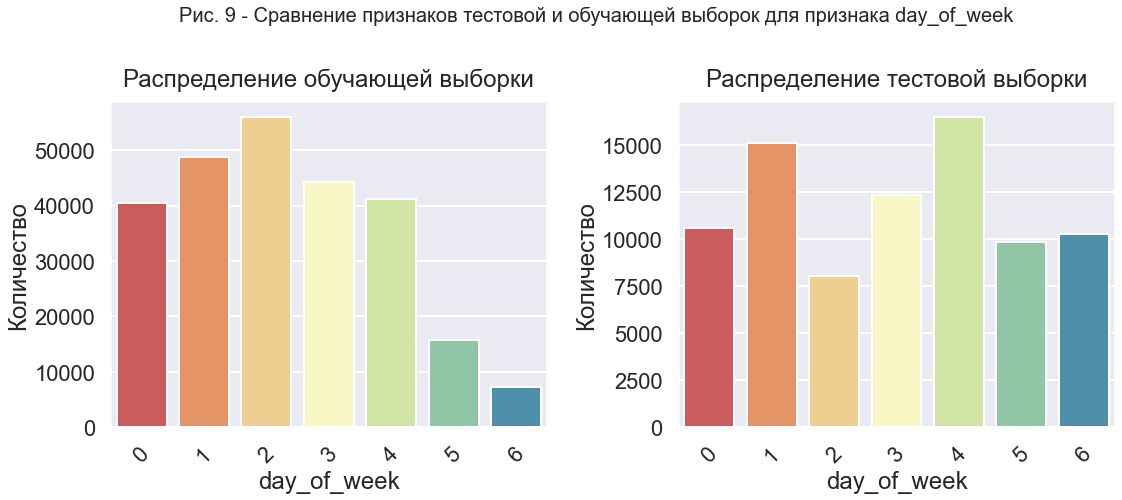

In [42]:
feature_list = ['unique', 'absolutely_unique_count',
                'start_hour', 'day_of_week'] 

for i, column_name in enumerate(feature_list): 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f"Рис. {i + 6} - Сравнение признаков тестовой и обучающей выборок для признака {column_name}",
                 fontsize=20, y=1.1)
    plt.subplots_adjust(wspace=0.3, hspace=3)
    sns.countplot(x=add_data_train[column_name], ax=ax1, palette='Spectral') 
    ax1.set_title("Распределение обучающей выборки", pad=15)
    ax1.set_ylabel('Количество')
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.countplot(x=add_data_test[column_name], ax=ax2, palette='Spectral')
    ax2.set_title("Распределение тестовой выборки", pad=15) 
    ax2.set_ylabel('Количество')
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

Мы можем заметить, что все признаки распределены примерно одинаково в обучающей и тестовой выборке.

Признак `start_hour` распределяется с 7 до 23 часов, а не с 0 до 23 часов, как ожидалось.

Далее проанализируем влияние признаков на целевую переменную.

In [43]:
def get_target_dist(column_name, i):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    plt.subplots_adjust(wspace=0.4)
    sns.countplot(x=add_data_train[add_data_train['target'] == 1][column_name],
                  ax=ax1) 
    fig.suptitle(f"Рис. {i} - Распределение признака {column_name} в срезе целевой метки", 
                 fontsize=30, y=1.1)
    ax1.set_ylabel('Количество')
    ax1.set_title('Распределение признака для взломщика (target=1)') 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.barplot(x=column_name, y="target", data=add_data_train, ax=ax2) 
    ax2.set_title('Пропорции признака для взломщика (target=1)') 
    ax1.set_ylabel('Процент')
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

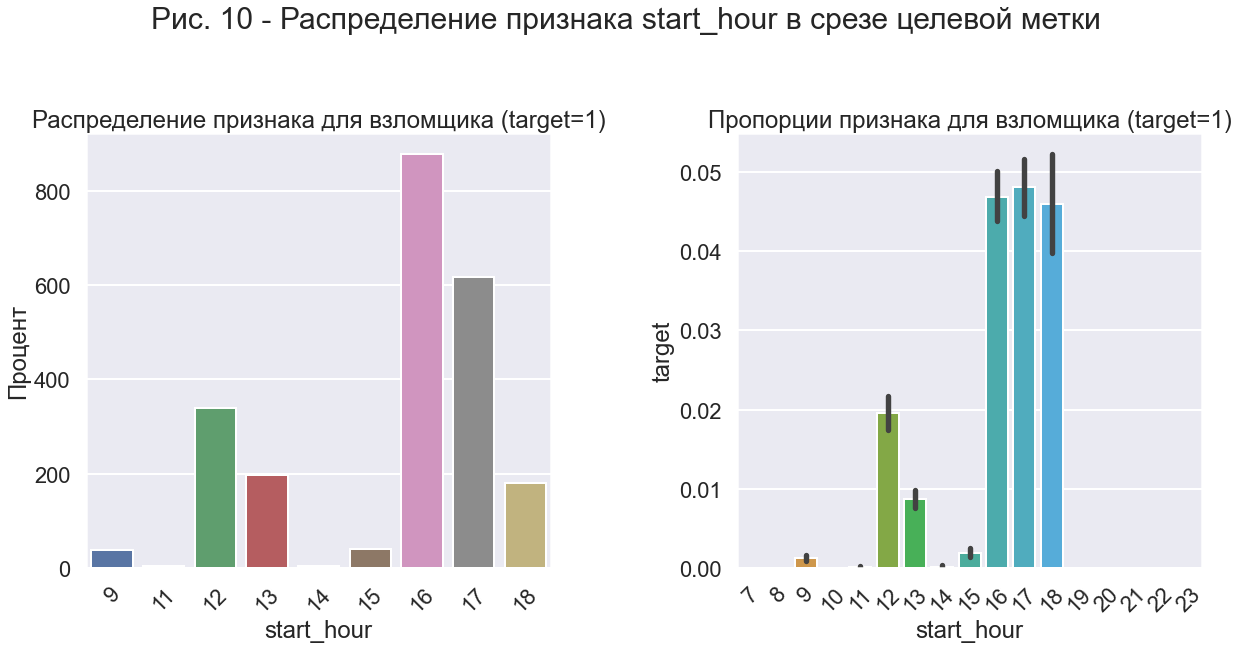

In [44]:
get_target_dist('start_hour', 10)

По рисунку видно, что мошеннические операции были зарегистрированы в период с 9 до 18 часов, причем период с 16 до 18 часов был наиболее насыщен подозрительной деятельностью. Исходя из этого, мы выделим 3 признака:

- утро: 7 - 11
- полдень: 12 - 15
- вечер: 16 - 20

In [45]:
add_data_train.loc[:, 'morning'] = add_data_train.loc[:, 'start_hour']\
                                                 .apply(lambda hour: int(hour >= 7 and hour <= 11 )) 
add_data_train.loc[:, 'midday'] = add_data_train.loc[:, 'start_hour']\
                                                 .apply(lambda hour: int(hour >= 12 and hour <= 18)) 
add_data_train.loc[:, 'evening'] = add_data_train.loc[:, 'start_hour']\
                                                 .apply(lambda hour: int(hour >= 19 and hour <= 23))
add_data_train.loc[:, 'night'] = add_data_train.loc[:, 'start_hour']\
                                                 .apply(lambda hour: int(hour >= 0 and hour <= 6))

add_data_test.loc[:, 'morning'] = add_data_test.loc[:, 'start_hour']\
                                                 .apply(lambda hour: int(hour >= 7 and hour <= 12 )) 
add_data_test.loc[:, 'midday'] = add_data_test.loc[:, 'start_hour']\
                                                 .apply(lambda hour: int(hour >= 12 and hour <= 18)) 
add_data_test.loc[:, 'evening'] = add_data_test.loc[:, 'start_hour']\
                                                 .apply(lambda hour: int(hour >= 19 and hour <= 23))
add_data_test.loc[:, 'night'] = add_data_test.loc[:, 'start_hour']\
                                                 .apply(lambda hour: int(hour >= 0 and hour <= 6))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


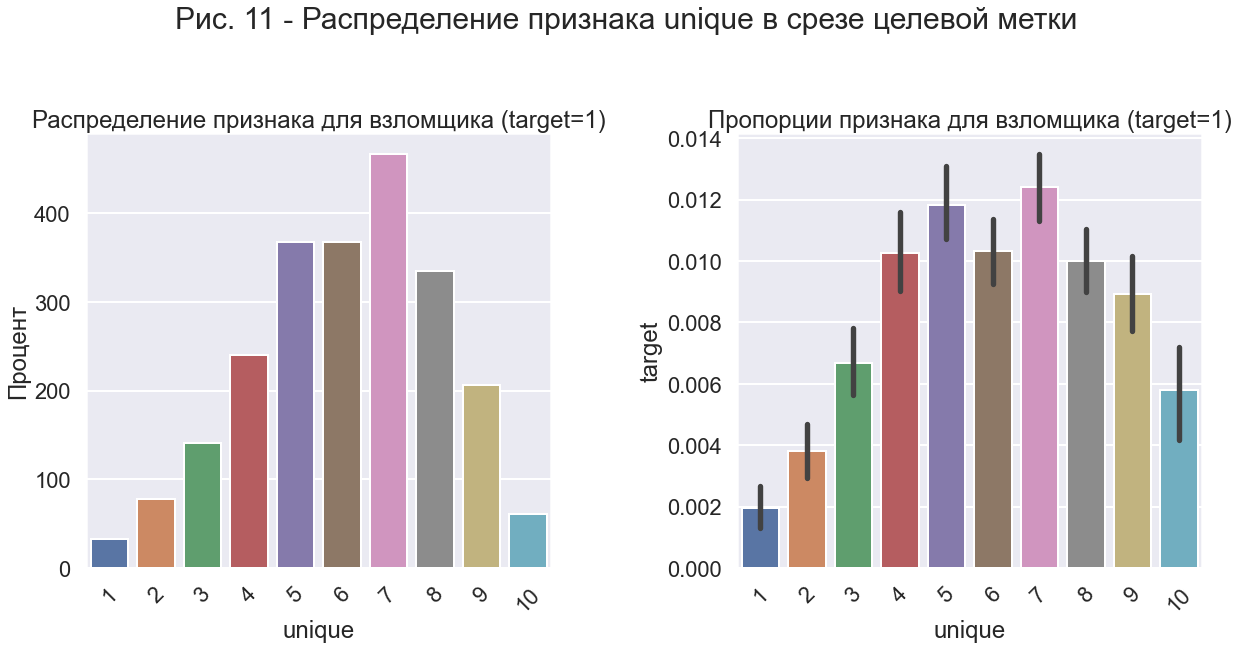

In [46]:
get_target_dist('unique', 11)

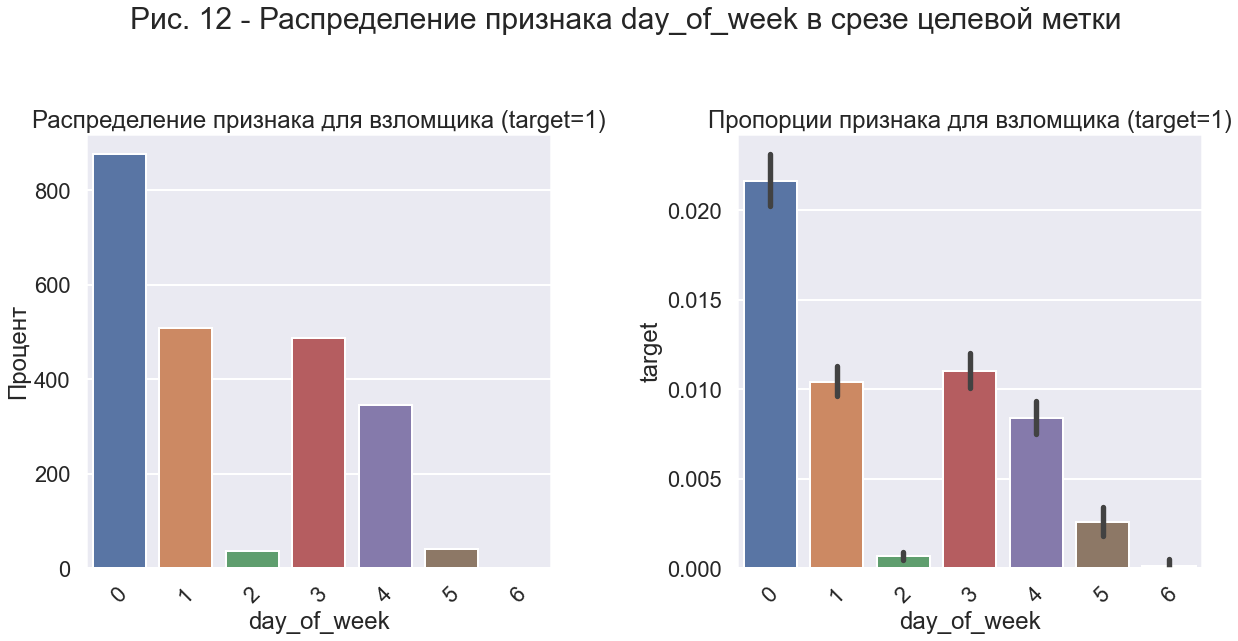

In [47]:
get_target_dist('day_of_week', 12)

Наименее подозрительная активность наблюдалась по средам, субботам и воскресеньям. А вот по понедельникам (`0`), наоборот, больше, чем в другие дни.

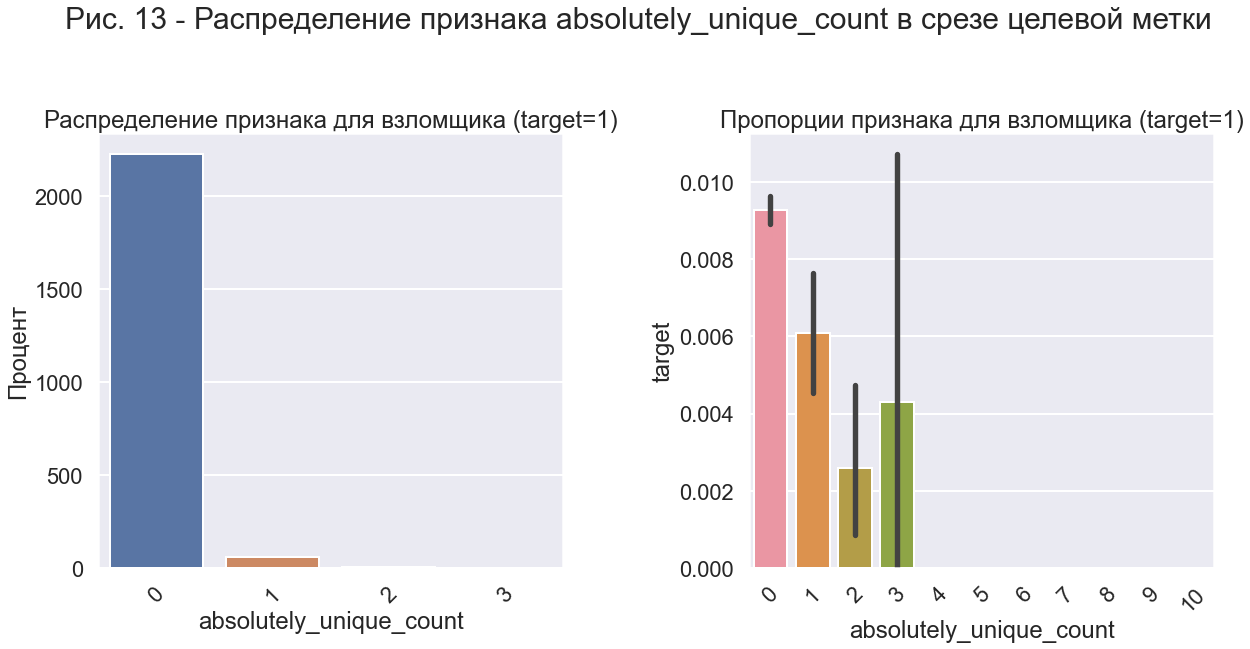

In [48]:
get_target_dist('absolutely_unique_count', 13)

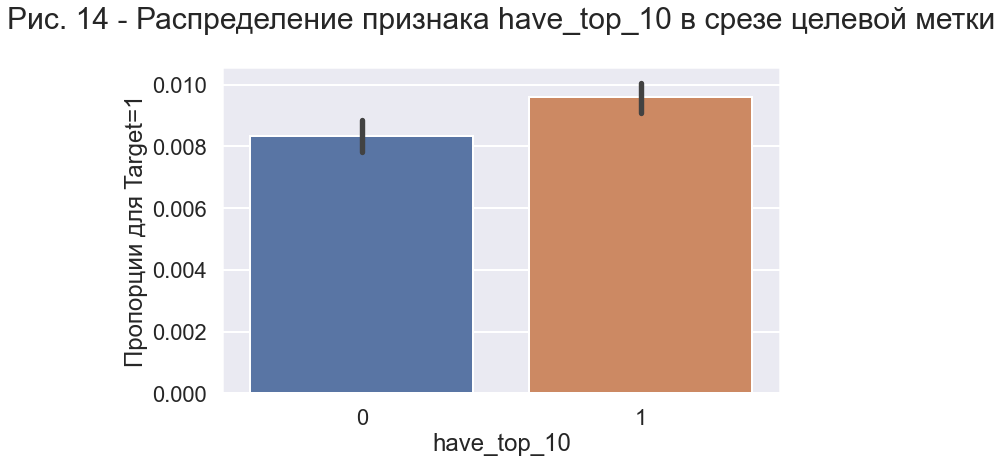

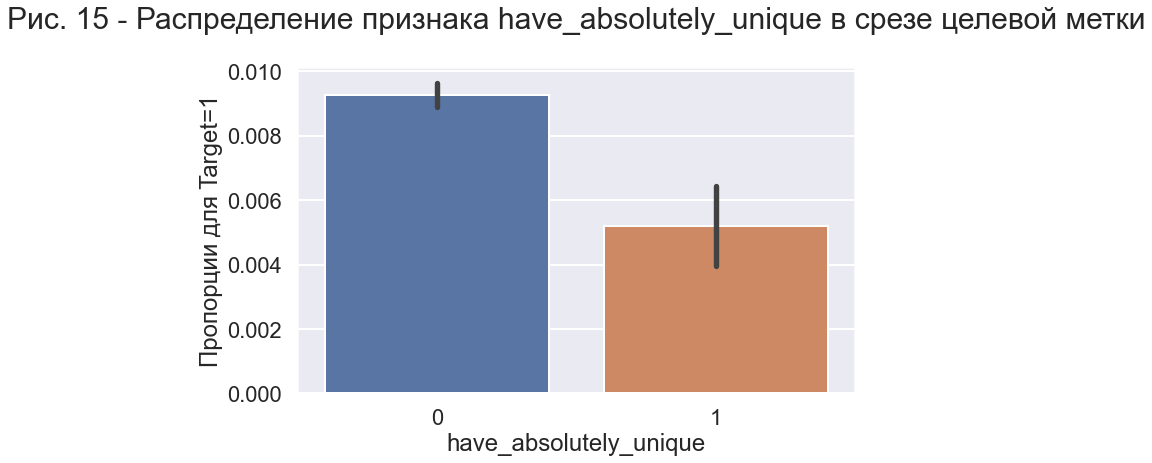

In [49]:
feature_list = ['have_top_10', 'have_absolutely_unique']

for i, column_name in enumerate(feature_list):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=column_name, y="target", data=add_data_train)
    plt.title(f"Рис. {i + 14} - Распределение признака {column_name} в срезе целевой метки", 
              fontsize=30, y=1.1)
    ax.set(ylabel='Пропорции для Target=1')
    plt.show()

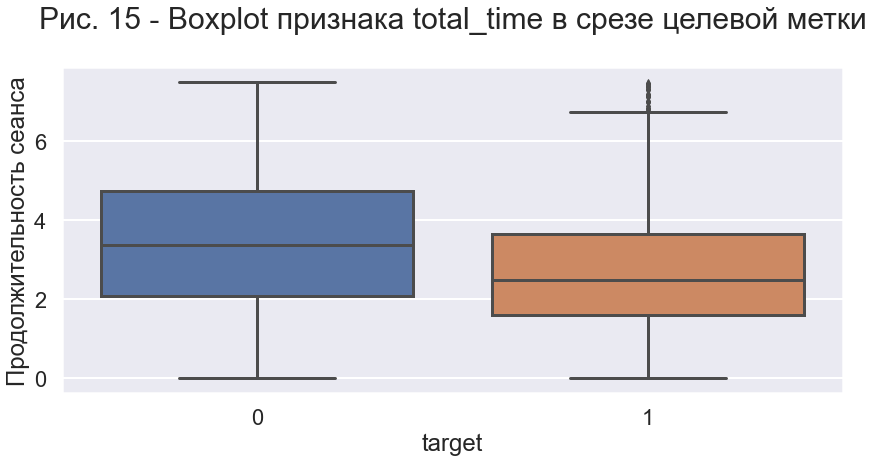

In [50]:
plt.figure(figsize=(14, 6))
plt.title(f'Рис. {i + 14} - Boxplot признака total_time в срезе целевой метки', 
          fontsize=30, y=1.1)
ax = sns.boxplot(x='target', y='total_time', data=add_data_train)
plt.ylabel('Продолжительность сеанса');

Продолжительность сеансов с подозрительной активностью в среднем меньше, чем у обычных .

__Общие замечания:__

Чаще всего подозрительная активность наблюдалась между 16 и 18 часами. Также по понедельникам чаще всего происходит подозрительная активность. В среднем продолжительность сеансов с подозрительной активностью меньше, чем у обычных.
Подозрительные сеансы реже встречаются на абсолютно уникальных сайтах (сайтах, которые встречаются только один раз в истории посещения сайтов).

Добавим циклические координаты

In [51]:
pi = np.pi

add_data_train.loc[:, 'hour_sin_x'] = add_data_train.loc[:, 'start_hour']\
                                .apply(lambda ts: np.sin(2*pi*ts/24.))
add_data_train.loc[:, 'hour_cos_x'] = add_data_train.loc[:, 'start_hour']\
                                .apply(lambda ts: np.cos(2*pi*ts/24.))

add_data_test.loc[:, 'hour_sin_x'] = add_data_test.loc[:, 'start_hour']\
                                .apply(lambda ts: np.sin(2*pi*ts/24.))
add_data_test.loc[:, 'hour_cos_x'] = add_data_test.loc[:, 'start_hour']\
                                .apply(lambda ts: np.cos(2*pi*ts/24.))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [52]:
def k_means_show(k, X, picture_num):
    
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    text_for_legend = []
    
    # изображаем цинтроиды
    fig, ax = plt.subplots(figsize=(14, 8))
    plt.title(f'Рис. {picture_num} - Кластеризация данных на {k}', 
              fontsize=30, y=1.1)
    for i in range(k):
        # выбераем только те наблюдения данных, которые с меткой кластера == i
        ds = X[np.where(labels==i)]
        # строим график данных наблюдений
        line = ax.plot(ds[:, 0], ds[:, 1], 'o')
        # показываем центроиды
        lines = plt.plot(centroids[i, 0], centroids[i, 1], 'x', 
                         color=line[0].get_color())
        # сделайте центроид X больше
        plt.setp(lines, ms=20)
        plt.setp(lines, mew=3)
        
        text_for_legend.append(f'Точки {i + 1}-го кластера')
        text_for_legend.append(f'Центроид {i + 1}-го кластера')
    plt.legend(text_for_legend)
    plt.show()
    return centroids

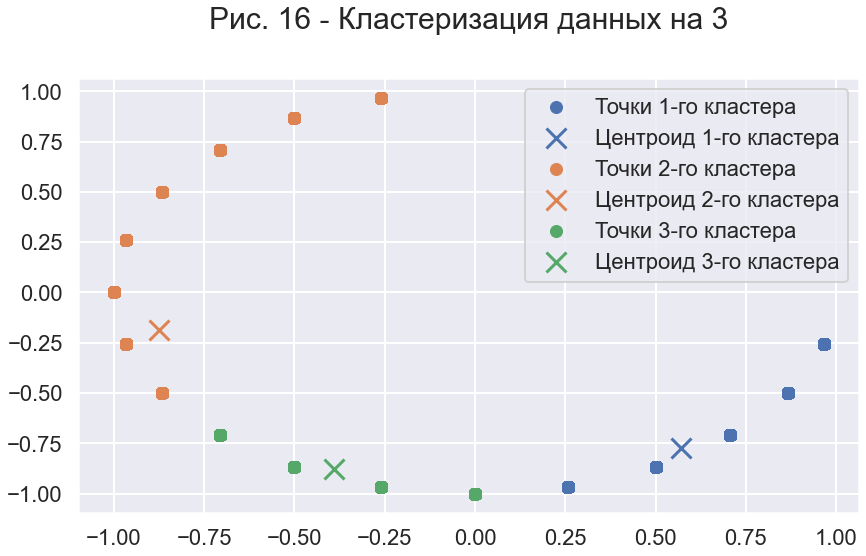

In [53]:
k_means_show(3, add_data_train[['hour_sin_x', 'hour_cos_x']].values, 16);

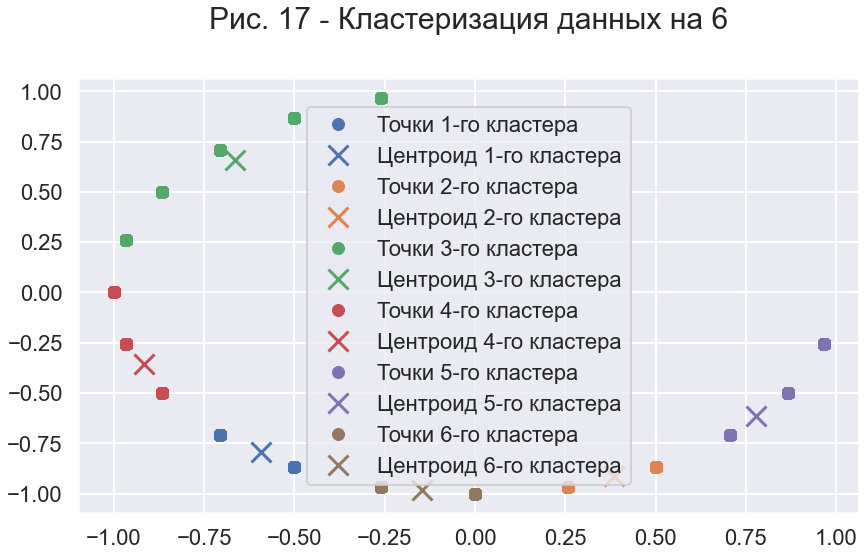

In [54]:
k_means_show(6, add_data_train[['hour_sin_x', 'hour_cos_x']].values, 17);

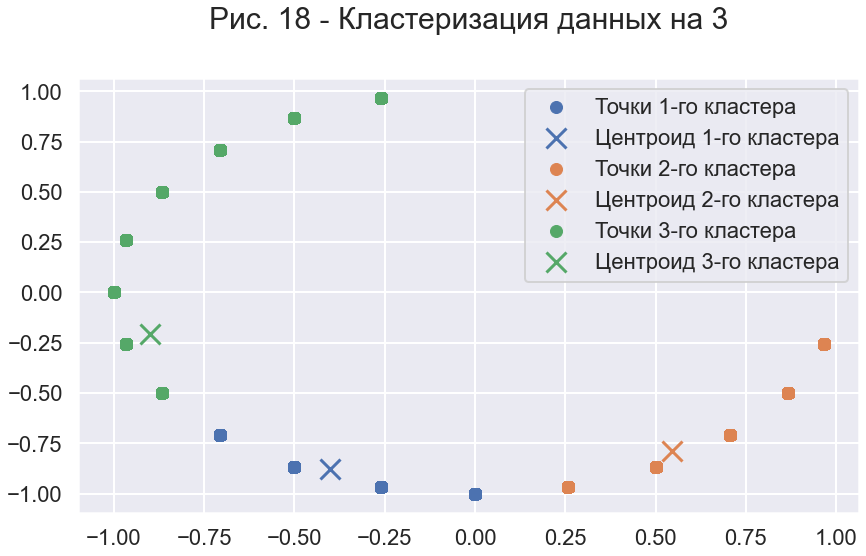

In [55]:
k_means_show(3, add_data_test[['hour_sin_x', 'hour_cos_x']].values, 18);

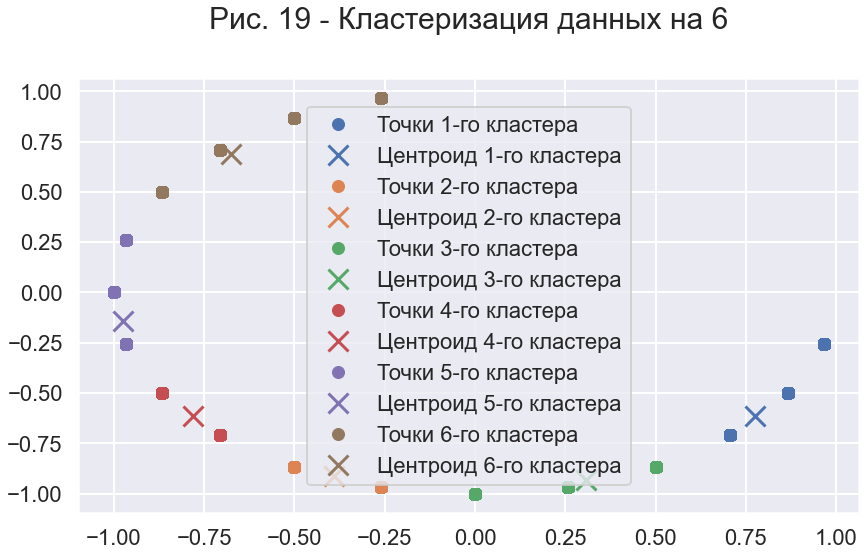

In [56]:
k_means_show(6, add_data_test[['hour_sin_x', 'hour_cos_x']].values, 19);

# Предварительная обработка данных

Преобразуем категориальные переменные с помощью `get_dummies`

In [57]:
add_train_dummies = pd.get_dummies(add_data_train, columns=['day_of_week']) 
add_train_dummies.drop(['target'], axis = 1, inplace=True) 
add_test_dummies = pd.get_dummies(add_data_test, columns=['day_of_week'])

Отмасштабируем данные с помощью `StandardScaler`

In [58]:
names_for_scale = ['time_diff' + str(x) for x in range (1,10)] \
                  +  ['unique', 'absolutely_unique_count', 'total_time'] 

scaler = StandardScaler()

for column_name in names_for_scale : 
    add_train_dummies[column_name] = scaler.fit_transform(add_train_dummies[column_name].values.reshape(-1, 1)) 
    add_test_dummies[column_name] = scaler.transform(add_test_dummies[column_name].values.reshape(-1, 1))

In [59]:
# Последовательность с индексами
sites_flatten = full_sites.values.flatten()

full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0], sites_flatten,  
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:] 
full_sites_sparse.shape

(336358, 48371)

Преобразуем сайты в вектора с помощью `TfidfVectorizer`

In [60]:
full_sites = full_df[sites].astype('str')
lst = full_sites[sites].values.tolist()
flat_list = [' '.join(sublist) for sublist in lst]

vect = TfidfVectorizer(ngram_range=(1, 5), max_features=200000,
                       analyzer='char_wb')

tfidf_matrix = vect.fit_transform(flat_list)

X_train_tf = tfidf_matrix[:idx_split]
X_test_tf = tfidf_matrix[idx_split:]

print(f'Размерность получившихся наборов данных: {X_train_tf.shape}, {X_test_tf.shape}')

Размерность получившихся наборов данных: (253561, 71593), (82797, 71593)


Объединим все получившиеся данные вместе.

In [61]:
x_train_full = csr_matrix(hstack([X_train_tf, add_train_dummies.values])) 
x_test_full = csr_matrix(hstack([X_test_tf, add_test_dummies.values])) 
print(f'Размерность получившихся объединенных данных: {x_train_full.shape}, {x_test_full.shape}')

Размерность получившихся объединенных данных: (253561, 71622), (82797, 71622)


## Разделение на train и valid датасеты

Для данной цели воспользуемся __Time Series cross-validator__, так как мы работает с последовательностью данных во времени.

In [62]:
target = train_df['target']
X_train, X_valid, y_train, y_valid = train_test_split(x_train_full,
                                                      target,
                                                      test_size=0.25) 
tscv = TimeSeriesSplit(n_splits=6);

In [63]:
[f'Размерность train{el[0].shape}, Размерность valid{el[1].shape}' 
 for el in tscv.split(X_train)]

['Размерность train(27168,), Размерность valid(27167,)',
 'Размерность train(54335,), Размерность valid(27167,)',
 'Размерность train(81502,), Размерность valid(27167,)',
 'Размерность train(108669,), Размерность valid(27167,)',
 'Размерность train(135836,), Размерность valid(27167,)',
 'Размерность train(163003,), Размерность valid(27167,)']

# Обучение моделей

Поскольку наши классы сильно несбалансированы, метрика точности здесь не подходит.

Мы будем использовать `ROC_AUC` в качестве метрики, а также посмотрим на результаты `confusion_matrix`

Поскольку у нас есть исторические данные, взаимосвязанные со временем, стандартная перекрестная подгонка в этом случае не сработает. Мы будем использовать кросс-валидацию с помощью методов кросс-валидации `TimeSeriesSplit` для временных рядов. Суть его заключается в следующем: мы делим образец, например, на 5 частей: `[1, 2, 3, 4, 5]`, затем мы тренируемся следующим образом

- Фолд 1: обучение `[1]`, тест `[2]`
- Фолд 2: обучение `[1, 2]`, тест `[3]`
- Фолд 3: обучение `[1, 2, 3]`, тест `[4]`
- Фолд 4: обучение `[1, 2, 3, 4]`, тест `[5]`
- Фолд 5: обучение `[1, 2, 3, 4, 5]`, тест `[6]`


Такой подход поможет лучше оценить качество алгоритма.

In [64]:
def train_model(model, **params):
    clf = model(**params)
    clf.fit(X_train, y_train)
    try:
        preds_val = clf.predict_proba(X_valid)[:, 1]
    except:
        preds_val = clf.predict(X_valid)
    
    print(f'Оценка {model.__name__} на вылидации: ROC-AUC = {round(roc_auc_score(y_valid, preds_val), 4)}')
    cross_score = np.mean(cross_val_score(clf, x_train_full, target, 
                                          scoring='roc_auc', cv=tscv))
    print(f'Оценка {model.__name__} на кросс-вылидации: ROC-AUC = {round(cross_score, 4)}')
    return clf

In [65]:
lr = train_model(LogisticRegression, random_state=RANDOM_SEED, n_jobs=-1, 
                 solver='lbfgs', max_iter=8000, class_weight='balanced')

Оценка LogisticRegression на вылидации: ROC-AUC = 0.9822
Оценка LogisticRegression на кросс-вылидации: ROC-AUC = 0.9026


In [66]:
rf = train_model(RandomForestClassifier, random_state=RANDOM_SEED, n_jobs=-1, 
                 n_estimators=300, class_weight='balanced')

Оценка RandomForestClassifier на вылидации: ROC-AUC = 0.974
Оценка RandomForestClassifier на кросс-вылидации: ROC-AUC = 0.8902


In [68]:
xgbc = train_model(xgb.XGBClassifier, random_state=RANDOM_SEED, n_jobs=-1, 
                   booster='gblinear', objective='binary:logistic')

Оценка XGBClassifier на вылидации: ROC-AUC = 0.9743
Оценка XGBClassifier на кросс-вылидации: ROC-AUC = 0.8371


In [69]:
sgdc = train_model(SGDClassifier, random_state=RANDOM_SEED, n_jobs=-1, 
                   max_iter=5000, penalty='elasticnet')

Оценка SGDClassifier на вылидации: ROC-AUC = 0.5155
Оценка SGDClassifier на кросс-вылидации: ROC-AUC = 0.8794


In [84]:
calibrator_sgdc = CalibratedClassifierCV(sgdc, cv='prefit')
calibrator_sgdc.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=5000,
                                                    n_iter_no_change=5,
                                                    n_jobs=-1,
                                                    penalty='elasticnet',
                                                    power_t=0.5, random_state=7,
                                                    shuffle=True, tol=0.001,
                                   

Построим ROC-кривые по предсказаниям моделей

In [85]:
fpr_lr, tpr_lr, threshold = roc_curve(y_valid, lr.predict_proba(X_valid)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, threshold = roc_curve(y_valid, rf.predict_proba(X_valid)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgbc, tpr_xgbc, threshold = roc_curve(y_valid, xgbc.predict_proba(X_valid)[:, 1])
roc_auc_xgbc = auc(fpr_xgbc, tpr_xgbc)

fpr_sgdc, tpr_sgdc, threshold = roc_curve(y_valid, calibrator_sgdc.predict_proba(X_valid)[:, 1])
roc_auc_sgdc = auc(fpr_sgdc, tpr_sgdc)

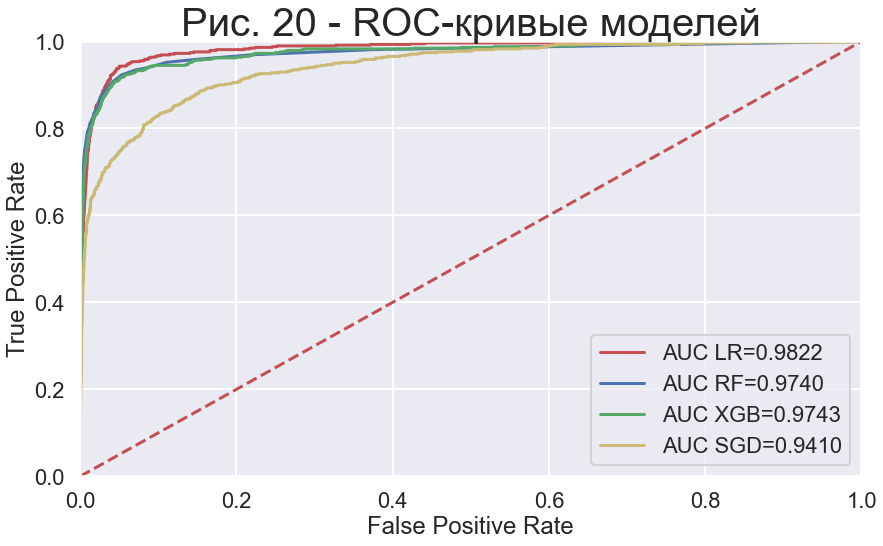

In [94]:
sns.set_context('poster')
plt.figure(figsize=(14, 8))
plt.title('Рис. 20 - ROC-кривые моделей', fontsize=40)
plt.plot(fpr_lr, tpr_lr,'r', label=f'AUC LR={roc_auc_lr:.4f}')
plt.plot(fpr_rf, tpr_rf,'b', label=f'AUC RF={roc_auc_rf:.4f}')
plt.plot(fpr_xgbc, tpr_xgbc,'g', label=f'AUC XGB={roc_auc_xgbc:.4f}')
plt.plot(fpr_sgdc, tpr_sgdc, 'y', label=f'AUC SGD={roc_auc_sgdc:.4f}')
plt.legend()
plt.plot([0,1], [0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

Лучше всего себя показала линейная регрессия.

## Поиск лучшего параметра для LR

С помощью `LogisticRegressionCV` подберем параметр `C` для `LogisticRegression`

In [146]:
logit_c_values = np.logspace(-3, 3, 7)

def grid_score(y_true, y_pred, **kwargs):
    return roc_auc_score(y_true, y_pred)

scorer = make_scorer(grid_score)

logit_grid_searcher = LogisticRegressionCV(Cs=logit_c_values,
                                           random_state=RANDOM_SEED,
                                           cv=tscv,
                                           n_jobs=-1,
                                           scoring=scorer,
                                           solver='lbfgs',
                                           max_iter=2000, 
                                           class_weight='balanced',
                                           verbose=3)

In [147]:
%%time

logit_grid_searcher.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  6.8min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 11.1min finished


CPU times: user 11min 44s, sys: 2min 15s, total: 14min
Wall time: 13min 12s


LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                     class_weight='balanced',
                     cv=TimeSeriesSplit(max_train_size=None, n_splits=6),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=2000, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=7, refit=True,
                     scoring=make_scorer(grid_score), solver='lbfgs',
                     tol=0.0001, verbose=3)

In [148]:
logit_mean_cv_scores = np.array(list(logit_grid_searcher.scores_.values()))\
                                .mean(axis = (0, 1))

In [149]:
best_score1 = np.amax(logit_mean_cv_scores)
best_C1 = logit_grid_searcher.Cs_[np.argmax(logit_mean_cv_scores)]

print(f'Лучшее среднее значение ROC-AUC: {best_score1} для С = {best_C1}')

Лучшее среднее значение ROC-AUC: 0.9376519427893878 для С = 1.0


Нарисуем график зависимости ROC-AUC score на кросс-валидации от `C`.

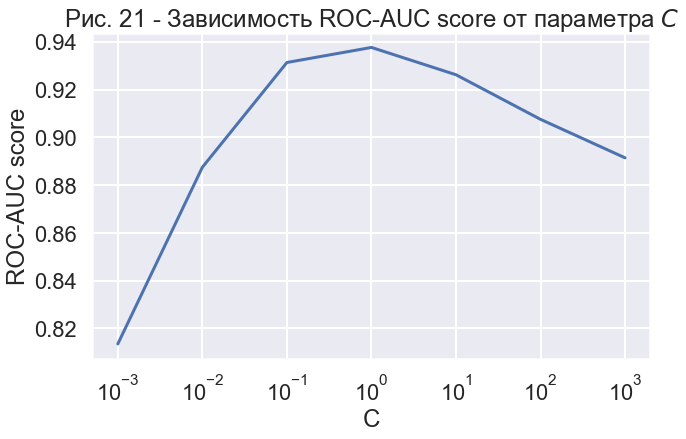

In [150]:
plt.figure(figsize=(10, 6))
sns.set_context('poster')
plt.title('Рис. 21 - Зависимость ROC-AUC score от параметра $C$')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('ROC-AUC score')
plt.plot(logit_c_values, logit_mean_cv_scores);

Теперь будем искать `C` в более узком диапазоне.

In [152]:
logit_c_values2 = np.linspace(0.1, 5, 10)


logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2,
                                           random_state=RANDOM_SEED,
                                           cv=tscv,
                                           n_jobs=-1,
                                           scoring=scorer,
                                           solver='lbfgs',
                                           max_iter=2000, 
                                           class_weight='balanced',
                                           verbose=3)

In [153]:
%%time

logit_grid_searcher2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  6.7min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 10.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 10.6min finished


CPU times: user 10min 26s, sys: 3min 11s, total: 13min 37s
Wall time: 12min 45s


LogisticRegressionCV(Cs=array([0.1       , 0.64444444, 1.18888889, 1.73333333, 2.27777778,
       2.82222222, 3.36666667, 3.91111111, 4.45555556, 5.        ]),
                     class_weight='balanced',
                     cv=TimeSeriesSplit(max_train_size=None, n_splits=6),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=2000, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=7, refit=True,
                     scoring=make_scorer(grid_score), solver='lbfgs',
                     tol=0.0001, verbose=3)

In [154]:
logit_mean_cv_scores2 = np.array(list(logit_grid_searcher2.scores_.values()))\
                                .mean(axis = (0, 1))

best_score2 = np.amax(logit_mean_cv_scores2)
best_C2 = logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]

print(f'Лучшее среднее значение ROC-AUC: {best_score2} для С = {best_C2}')

Лучшее среднее значение ROC-AUC: 0.93884405801571 для С = 0.6444444444444445


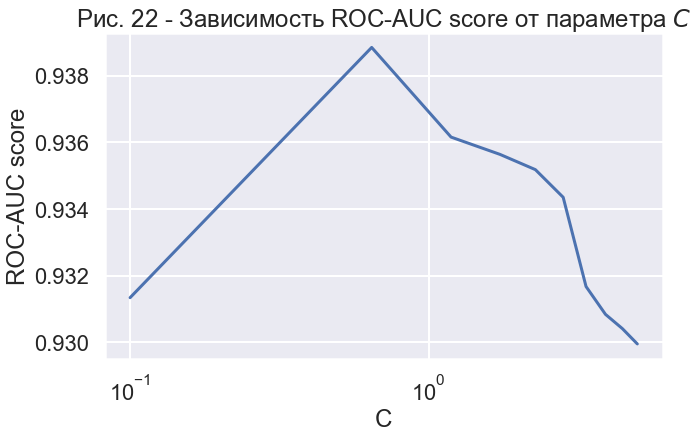

In [155]:
plt.figure(figsize=(10, 6))
sns.set_context('poster')
plt.title('Рис. 22 - Зависимость ROC-AUC score от параметра $C$')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('ROC-AUC score')
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Обучим логистическую регрессию на всей тренировочной выборке с лучшим значением `C`.

In [156]:
%%time

lr_best = LogisticRegression(C=best_C2,
                             random_state=RANDOM_SEED, n_jobs=-1, 
                             solver='lbfgs', max_iter=8000,
                             class_weight='balanced')

lr_best.fit(X_train, y_train)

CPU times: user 101 ms, sys: 227 ms, total: 327 ms
Wall time: 1min 40s


LogisticRegression(C=0.6444444444444445, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=8000, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [157]:
print('ROC_AUC на валидации: {} '.format(
      round(roc_auc_score(y_valid, lr_best.predict_proba(X_valid)[:, 1]), 4)))

ROC_AUC на валидации: 0.9817 


Напишем функции для отправки записи предсказаний для отправки

In [158]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [166]:
preds = lr_best.predict_proba(x_test_full)[:, 1]

In [ ]:
write_to_submission_file(preds, 'kaggle_ans/submission.csv')

Результат: `0.93423`

Название команды: `[YDF & MIPT] Coursera_VVD`

# Выводы

Была получена модель логистической регрессии, способная идентифицировать конкретного пользователя среди других на основе сгенерированных признаков. Был получен результат ROC-AUC score равный `0.93423` на тестовых данных. 